# Seth Hyatt - STAT 426 Final Project - Financial Analytics and Predictions

## Introduction and Data Collection

How much money am I going to spend on various categories over the first three months of 2021? That is the question I would like to solve using the Data Analytics skills I have learned this semester. This answer will come from predicting 'Amount' values from different models. The data I have available to help answer this question comes from my monthly transaction reports from my Apple Card since November 2019, as I use my Apple Card for most purchases. 

The first step in any analytical project is to read in the Data and necessary Libraries. This is done and shown below.

In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import itertools

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
# List out the Data available
os.listdir('APPLE Card Spending/')

['Apple Card Transactions - April 2020.csv',
 'Apple Card Transactions - August 2020.csv',
 'Apple Card Transactions - December 2019.csv',
 'Apple Card Transactions - February 2020.csv',
 'Apple Card Transactions - January 2020.csv',
 'Apple Card Transactions - July 2020.csv',
 'Apple Card Transactions - June 2020.csv',
 'Apple Card Transactions - March 2020.csv',
 'Apple Card Transactions - May 2020.csv',
 'Apple Card Transactions - November 2019.csv',
 'Apple Card Transactions - October 2020.csv',
 'Apple Card Transactions - September 2020.csv']

For the Data to be useful, all separate tables listed out above need to be concatenated into one. So, let's do that. Let's also take a look at how the data is structured.

In [3]:
# Concatenate all files into one Data set
all_transactions = pd.DataFrame()

for file in os.listdir('APPLE Card Spending/'):
    df = pd.read_csv('APPLE Card Spending/' + file)
    all_transactions = all_transactions.append(df, ignore_index = True)
    
print('Dimensions of Data: ' + str(all_transactions.shape))
print('Quick look at the Data:')
all_transactions.head(3)

Dimensions of Data: (612, 7)
Quick look at the Data:


,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount (USD)
0,04/28/2020,04/30/2020,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,5.35
1,04/28/2020,04/28/2020,MAVERIK #517 24 S GENEVA ROAD VINEYARD 84058 U...,Maverik,Gas,Purchase,10.64
2,04/28/2020,04/28/2020,MICROSOFT*ULTIMATE 1 MONE MICROSOFT WAY MSBILL...,Microsoft,Other,Purchase,16.08


The "raw" data has 612 observations with 7 columns. The column 'Amount (USD)' is the response variable I will be trying to predict later; the other 6 are explanatory variables with varying levels of utility. 

Since the Apple Card is a credit card, I have to pay off the balance from time to time. Since paying off my balances contributes no information to how I *spend* my money, I need to remove all observations when this happens.

In [4]:
# Get rid of rows where I paid off my balance - Only interested in EXPENSES
pay_off = all_transactions.iloc[9]['Description']
print('Description for Payment: ' + str(pay_off)[:-4] + '****')

pay_off_indeces = all_transactions[all_transactions['Description'] == pay_off].index[:]
print('Number of Payments: ' + str(len(pay_off_indeces)))

all_transactions = all_transactions.drop(pay_off_indeces)
print('Number of Rows Leftover: ' + str(len(all_transactions)))

Description for Payment: ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT ENDING IN ****
Number of Payments: 39
Number of Rows Leftover: 573


Understanding the 'Description' for all observations where I paid off my balance (printed above), I took out all 39 of these rows. Therefore, there are now only 573 observations in the data.

## Wrangling the Data and Feature Engineering

There is some more information we can add to the dataset, as well as some we can parse out. 

First, let's make the 'Transaction Date' and 'Clearing Date' into date values, since that's what the actually are.

Second, we can extract the 'Year', 'Month', and 'Day' from the 'Transaction Date' in order for the date to play a numerical role later.

Thrid, we can pull the state from the 'Description' variable. This 'State' refers to the state the company is based out of, not necessarily the state the purchase was made in. So, we can make this new 'State' variable, but it will not play any practical importance in modeling. Similarly, the 'Type' variable plays no importance because every value is either "Purchase" or, in only four instances, "Refund". I will be leaving these refunded payments in, becasue unlike paying off my balances, these negative values to contribute to how much I spend.

Fourth, we can create a 'Season' variable based on the time of year. 

Fifth, we can create two Boolean variables, 'InSchool' and 'Employed'. These variables are 0 when I am either out of school (summer break) or unemployed (because of COVID-19) respectively. 

Lastly, after creating all these variables, let's take another look at our data's structure.

In [5]:
### Feature Engineering ###

# Date Variables
all_transactions['Transaction Date'] = pd.to_datetime(all_transactions['Transaction Date'])
all_transactions['Year'] = all_transactions['Transaction Date'].dt.year
all_transactions['Month'] = all_transactions['Transaction Date'].dt.month
all_transactions['Day'] = all_transactions['Transaction Date'].dt.day
all_transactions['Clearing Date'] = pd.to_datetime(all_transactions['Clearing Date'])

# State of Company (hard to gather information from)
all_transactions['State'] = all_transactions['Description'].apply(lambda x: x[-6:-4])

# Season and InSchool
for i in all_transactions.index[:]:
    if all_transactions.loc[i, 'Transaction Date'].month in [12, 1, 2]:
        all_transactions.loc[i, 'Season'] = 'Winter'
        all_transactions.loc[i, 'InSchool'] = 1
    elif all_transactions.loc[i, 'Transaction Date'].month in [3, 4, 5]:
        all_transactions.loc[i, 'Season'] = 'Spring'
        all_transactions.loc[i, 'InSchool'] = 1
    elif all_transactions.loc[i, 'Transaction Date'].month in [6, 7, 8]:
        all_transactions.loc[i, 'Season'] = 'Summer'
        all_transactions.loc[i, 'InSchool'] = 0
    elif all_transactions.loc[i, 'Transaction Date'].month in [9, 10, 11]:
        all_transactions.loc[i, 'Season'] = 'Autumn'
        all_transactions.loc[i, 'InSchool'] = 1
        
# Employment (because of COVID)
for i in all_transactions.index[:]:
    if all_transactions.loc[i, 'Transaction Date'].month in [1, 2, 3, 9, 10, 11, 12]:
        all_transactions.loc[i, 'Employed'] = 1
    elif all_transactions.loc[i, 'Transaction Date'].month in [4, 5, 6, 7, 8]:
        all_transactions.loc[i, 'Employed'] = 0
        
print('Dimensions of Data after new variables: ' + str(all_transactions.shape))
print("Let's take another look at the Data:")
all_transactions.head(3)

Dimensions of Data after new variables: (573, 14)
Let's take another look at the Data:


,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount (USD),Year,Month,Day,State,Season,InSchool,Employed
0,2020-04-28,2020-04-30,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,5.35,2020,4,28,CA,Spring,1.0,0.0
1,2020-04-28,2020-04-28,MAVERIK #517 24 S GENEVA ROAD VINEYARD 84058 U...,Maverik,Gas,Purchase,10.64,2020,4,28,UT,Spring,1.0,0.0
2,2020-04-28,2020-04-28,MICROSOFT*ULTIMATE 1 MONE MICROSOFT WAY MSBILL...,Microsoft,Other,Purchase,16.08,2020,4,28,WA,Spring,1.0,0.0


After engineering these new features, the data now has 14 columns, with 13 of them being possible explanatory variables. 

Now, since the 'Description' variable has no common structure to parse, the most useful variable becomes 'Category'. This 'Category' variable decribes what kind of purchase I made. Below is how many and what kinds of categories the original data created.

In [6]:
# Number and Names of Categories automatically defined by the report
print(len(all_transactions['Category'].unique()))
list(all_transactions['Category'].unique())

11


['Other',
 'Gas',
 'Restaurants',
 'Debit',
 'Grocery',
 'Shopping',
 'Entertainment',
 'Insurance',
 'Hotels',
 'Transportation',
 'Airlines']

I do not think the above 11 categories are enough to aptly describe my spending. So, let's make some more. Let's first start with the 'Category' "Other". Within this category, I can make a few more.

In [7]:
### Manipulating the Category 'Other' ###

# XBOX
all_transactions.loc[all_transactions['Merchant'] == 'Microsoft', 'Category'] = 'XBOX'

# Car Stuff
all_transactions.loc[(all_transactions['Merchant'] == 'University Mall Big O') | 
                    (all_transactions['Merchant'] == 'Quick Quack Car Wash') |
                    (all_transactions['Merchant'] == 'Quickquack* #0701 Wash'), 'Category'] = 'Transportation'

# School Stuff
all_transactions.loc[(all_transactions['Merchant'] == 'www.myeducator.com') |
                    (all_transactions['Merchant'] == 'BYU Store') |
                    (all_transactions['Merchant'] == 'University Parking Enforcement'), 'Category'] = 'School Stuff'

# Tech Stuff
all_transactions.loc[(all_transactions['Merchant'] == 'Verizon Wireless') |
                    (all_transactions['Merchant'] == 'Zagg') |
                    (all_transactions['Merchant'] == 'Samscheiner Eb (Paypal)') |
                    (all_transactions['Merchant'] == 'Best Buy') |
                    (all_transactions['Merchant'] == 'Apple Services') |
                    (all_transactions['Merchant'] == 'Apple Store'), 'Category'] = 'Tech Stuff'

The 'Category' "Restaurants" is also quite vague. So, let's make a couple distinctions within this category: "Pizza", "Real Food", and "Fast Food or Snacks".

In [8]:
### Manipulating the Category 'Restaurants' ###

# Pizzas
pizza = ["Papa John's", "Domino's Pizza", 'Little Caesars', "Papa Murphy's", 'Pie Pizzeria', 'Little Caesars 20068',
         'Pizza Hut']

# Real Food
real_food = ['Straw Market', "P. F. Chang's", 'Trureligion Pancake an', 'Baja Cantina', "Chili's Grill & Bar",
             'Maria Bonita', 'IHOP', 'Noodles & CO 705', 'Olive Garden', 'Mi Ranchito', 'Rumbi Island Grill',
             'Tepanyaki Japanese', 'Outback Steakhouse', 'Waffle House', 'Cuts Steakhouse', 'Bbdiner Orem #178',
             'Kneaders Bakery & Cafe', 'DoorDash', 'Texas Roadhouse', 'Rise by Good Day']

# Replace the string 'Restaurants' with a more appropriate label
for i in all_transactions[all_transactions['Category'] == 'Restaurants'].index[:]:
    if all_transactions[all_transactions['Category'] == 'Restaurants'].loc[i, 'Merchant'] in pizza:
        all_transactions.loc[i, 'Category'] = 'Pizza'
    elif all_transactions[all_transactions['Category'] == 'Restaurants'].loc[i, 'Merchant'] in real_food:
        all_transactions.loc[i, 'Category'] = 'Real Food'
    else:
        all_transactions.loc[i, 'Category'] = 'Fast Food or Snacks' # Just a catch all

Finally, the "Entertainment" 'Category' included a value "Cinemark". Cinemark is where I used to work, and any purchases there would have been food I would have purchased for breaks. Since these amounts do not describe actual entertainment, I will combine these amounts with "Fast Food or Snacks".

In [9]:
### Manipulating the Category 'Entertainment' ###

# Cinemark (where I work)
all_transactions.loc[all_transactions['Merchant'] == 'Cinemark Theatres', 'Category'] = 'Fast Food or Snacks'

Now that we are done with feature engineering, let's observe how many categories we now have, as well as their names.

In [10]:
# Number of Categories after all the engineering
print(len(all_transactions['Category'].unique()))
list(all_transactions['Category'].unique())

16


['Tech Stuff',
 'Gas',
 'XBOX',
 'Pizza',
 'Fast Food or Snacks',
 'Debit',
 'Other',
 'Grocery',
 'Shopping',
 'Transportation',
 'Real Food',
 'Entertainment',
 'Insurance',
 'School Stuff',
 'Hotels',
 'Airlines']

16 categories seems to be enough for me. While the "Other" 'Category' still exists, I believe it is more useful now that it has been somewhat spliced.

## Exploratory Data Analysis

As we should do with any data-based project, let's perform some exploratory data analytics by creating a few different types of graphs representing the data we now have. Let's start with some numeric summaries.

In [11]:
# View numeric Data summaries
cat_sum = pd.DataFrame(all_transactions.groupby('Category')['Amount (USD)'].sum())
cat_stats = all_transactions.groupby('Category')['Amount (USD)'].describe()
numerics = pd.merge(cat_stats, cat_sum, left_index = True, right_index = True)
numerics

,count,mean,std,min,25%,50%,75%,max,Amount (USD)
Category,,,,,,,,,
Airlines,5.0,299.620000,351.076319,-282.20,282.2000,347.700,575.2000,575.20,1498.10
Debit,4.0,1.540000,1.352997,0.24,0.4425,1.550,2.6475,2.82,6.16
Entertainment,11.0,46.433636,130.331326,-258.50,10.8000,35.380,110.5000,266.00,510.77
Fast Food or Snacks,195.0,14.486872,11.057935,1.20,8.6900,12.000,17.5000,117.64,2824.94
Gas,105.0,12.554952,11.454630,1.38,4.6500,7.500,15.1400,40.00,1318.27
Grocery,60.0,30.841833,35.312749,2.48,10.6175,21.915,36.1775,223.74,1850.51
Hotels,1.0,30.350000,NaN,30.35,30.3500,30.350,30.3500,30.35,30.35
Insurance,5.0,11.286000,19.860776,-23.63,15.5000,17.300,23.6300,23.63,56.43
Other,45.0,37.901556,58.132209,-51.00,10.1400,24.000,45.0000,321.75,1705.57


In [12]:
# Boolean Proportions
all_transactions[['InSchool', 'Employed']].describe()

,InSchool,Employed
count,573.000000,573.000000
mean,0.738220,0.631763
std,0.439988,0.482748
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Looking at the above summaries, we can actually learn quite a bit. 

The 'Category' with the most transactions is "Fast Food or Snacks", which also was where I spent the most money (oof). "Tech Stuff" only has 22 purchases, but is the second most expensive.

I was in school for 74% of the year, which makes sense. 

I was only employed for 63% of the year; thanks Covid!

Now let's look at some graphs than can show the data in different ways.

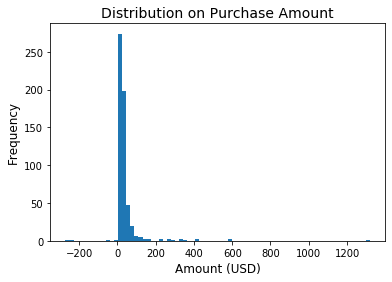

In [13]:
# Histogram of Amounts
plt.hist(all_transactions['Amount (USD)'], bins = 75, align = 'right')

plt.title('Distribution on Purchase Amount', fontsize = 14)
plt.xlabel('Amount (USD)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

Telling from the above graph, there is very large range of purchase amounts, but most are concentrated below $200. Let's zoom in a bit.

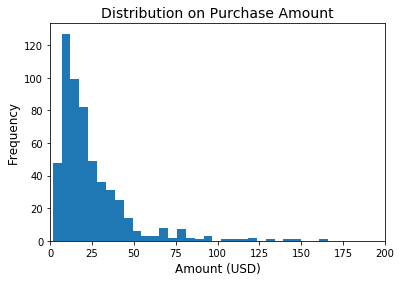

In [14]:
# Histogram of Amounts
plt.hist(all_transactions['Amount (USD)'], bins = 300, align = 'right')

plt.title('Distribution on Purchase Amount', fontsize = 14)
plt.xlabel('Amount (USD)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.xlim(0, 200)

plt.show()

This zoomed in histogram shows us that the vast majority of purchases are under $50. 

The most common purchase is between $5-10.

Now, let's look at purchases over time.

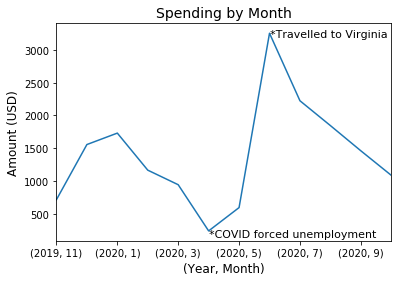

In [15]:
# Totals by Month
all_transactions.groupby([all_transactions['Year'],
                          all_transactions['Month']])['Amount (USD)'].sum().plot()

plt.title('Spending by Month', fontsize = 14)
plt.ylabel('Amount (USD)', fontsize = 12)
plt.xlabel('(Year, Month)', fontsize = 12)
text = '*COVID forced unemployment'
text2 = '*Travelled to Virginia'
plt.text(5, 150, text, fontsize = 11)
plt.text(7, 3200, text2, fontsize = 11)

plt.show()

Let's see what kind of information we can get from the above graph.

It looks like my spending increased around the holidays in 2019. This makes perfect sense. Additionally, my purchases go down during Winter semester and plumets when I am laid off from work becasue of COVID-19. Surprisingly though, my purchases sky-rocket in June. This I can attribute to 1) receiving unemployment insurance (which was more than I was making at work), and 2) purchasing plane tickets for my travel to Virginia when my grandmother died. Post June, my expenses are still relatively high, as I am continuing to receive unemployment insurance, but the expenses steadily decrease as the year continued.

Now that we've see how much money I am spending across time, let's look how that money is being spent by analyzing the categories.

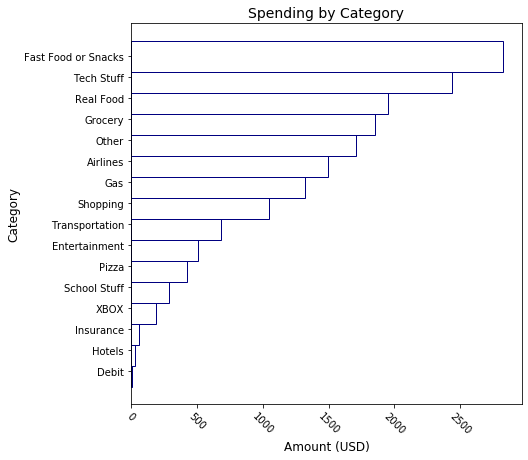

In [16]:
# Totals by Category
sorted_amounts = numerics.sort_values('Amount (USD)')
sorted_amounts.index

plt.figure(figsize=(7, 7))
plt.barh(sorted_amounts.index, sorted_amounts['Amount (USD)'], height = 1.5, color = 'white', edgecolor = 'navy')

plt.title('Spending by Category', fontsize = 14)
plt.ylabel('Category', fontsize = 12)
plt.xlabel('Amount (USD)', fontsize = 12)
plt.xticks(rotation = -45)

plt.show()

It looks like the "Fast Food or Snacks" 'Category' has the most expenses, just as we saw with the numerical summaries. This graph also makes it easier to see a sort of hierarchy in how I spent money. For example, it's easy to see that I spent more money on "Pizza" in a year than I did on "School Stuff".

To close this EDA segment, let's look at my spending habits based on my two Boolean variables, "InSchool" and "Employed".

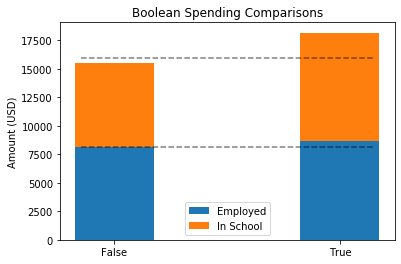

In [17]:
# Stacked Bar of Employed and InSchool Spending
x = range(2)
emp = all_transactions.groupby('Employed')['Amount (USD)'].sum().values
schl = all_transactions.groupby('InSchool')['Amount (USD)'].sum().values

plt.bar(x, emp, label = 'Employed', width = 0.35)
plt.bar(x, schl, bottom = emp, label = 'In School', width = 0.35)

plt.hlines(y = emp[0], xmin = -0.15, xmax = 1.15, linestyles = 'dashed', alpha = 0.5)
plt.hlines(y = (emp[1] + schl[0]), xmin = -0.15, xmax = 1.15, linestyles = 'dashed', alpha = 0.5)

plt.title('Boolean Spending Comparisons')
plt.ylabel('Amount (USD)')
plt.xticks(ticks = [0, 1], labels = ['False', 'True'])
plt.legend(loc = "lower center")

plt.show()

According to the graph above, I spent just a little more money when I was Employed than when I was not. Normally, one would probably expect a larger margin here, but as I have stated previously, I collected more money through unemployment insurance than what I was paid at work (and I'm bad at saving money).

The graph also tells us I spent decently more money while I was in school than during summer vacation. This may be because I am in school for more time overall, but also because holidays like Christmas and Valentine's Day occur during the months I'm in school.

### Reformat the Data

Now that we have reviewed and explored the data, it's time to move toward modeling. Before we get deep in models, however, we should figure out what the end result should look like.

Below is the data reformatted to show how much money I spent on each category for each month of data I have. This is what I want the results of my predictions to look like, but for January-March of next year.

In [18]:
# Pivot table of original Data
cat_pivot = all_transactions.pivot_table(index = all_transactions['Month'],
                                         values = 'Amount (USD)', columns = 'Category', aggfunc = 'sum')
cat_pivot = cat_pivot.fillna(0)
cat_pivot

Category,Airlines,Debit,Entertainment,Fast Food or Snacks,Gas,Grocery,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
Month,,,,,,,,,,,,,,,,
1,0.0,0.00,266.00,437.92,146.62,42.92,0.00,17.30,122.35,12.09,352.74,73.28,34.34,224.60,0.00,1.07
2,0.0,0.00,35.38,287.56,148.55,120.44,0.00,0.00,130.07,15.89,263.61,0.00,0.00,5.35,143.40,16.08
3,0.0,0.00,0.00,261.47,188.51,236.05,0.00,0.00,-10.47,49.02,117.67,75.00,0.00,5.35,0.00,21.78
4,0.0,0.51,0.00,19.49,91.14,0.00,0.00,0.00,0.00,81.05,0.00,0.00,0.00,5.35,0.00,42.34
5,0.0,5.65,-243.05,55.26,113.11,274.13,0.00,0.00,223.03,48.85,19.99,0.00,0.00,82.48,0.00,16.08
6,1150.4,0.00,248.95,339.38,100.55,345.99,30.35,0.00,132.99,69.87,196.37,0.00,115.72,471.17,36.00,16.08
7,0.0,0.00,0.00,203.91,91.07,45.23,0.00,0.00,65.20,96.79,10.00,75.00,0.00,1601.23,19.99,16.08
8,0.0,0.00,0.00,239.86,130.59,48.90,0.00,0.00,504.76,0.00,262.89,0.00,204.31,5.35,422.66,26.78
9,347.7,0.00,40.74,168.09,81.17,195.69,0.00,23.63,105.06,0.00,46.98,61.47,330.20,15.00,29.99,16.08


Some explanatory variables are factors. So, these variables need to be converted into dummy varaibles for modeling. This needs to be done for 'Season' and 'Category'. Additionally, we need to drop the other explanatory variables that would play no part in modeling, like 'Transaction Date', 'Description', 'Merchant', and some others. The finalized data is shown below. 

Another note on reformating the data for modeling. After making the dummy variables and proceeding with modeling and predicting, the predictions were terrible. I believe this is because the models never once predicted a value of 0 for any amount. At first quite puzzled by this, I realized this is becasue the original data never has an expense of 0; why would it, the data is only of my expenses. But, because we predict how much money I will spend in each category each day, there should be several days I spend nothing. Certainly, I should not be spending money in all 16 categories every single day - this is what was originally being predicted. So, to fix this, I have had to reconstruct the modeling data. This data will mirror the 'future data' we will get to soon. Each day will be repeated 16 times, once per category, and will have a 0 if I did not spend money on the category that day, and the actual values that I did spend. Then, building the other columns like 'Season' and others will be done just as it was before, only dummy variables will then be added to account for the factors as mentioned above.

And while this may take a little bit of time to run, it is important to get accurate and practical predictions.

In [19]:
### Rearrange the Data for Modeling ###

# Build an empty Data Frame to start
modeling_data = pd.DataFrame()

# Transaction Date - 16 categories, so 16 rows per date
date_rng = pd.date_range(start = '11/15/2019', end = '10/30/2020')
date_rng_cat = list(itertools.chain.from_iterable(
    itertools.repeat(x, len(all_transactions['Category'].unique()))
    for x in date_rng))
modeling_data['Transaction Date'] = date_rng_cat

# Fill all Amount values to be 0
modeling_data.loc[:, 'Amount (USD)'] = 0

# Replicate the 16 categories per day
modeling_data['Category'] = (list(all_transactions['Category'].unique())
                           * int(len(date_rng_cat) / len(all_transactions['Category'].unique())))

# Merge the 'empty data' with the original expenses and sum up by day -
# one category per day with a total amount spent on that category that day
modeling_data = pd.concat([modeling_data,
                           all_transactions[['Transaction Date', 'Category', 'Amount (USD)']]],
                          sort = False, ignore_index = False)
modeling_data = modeling_data.sort_values('Transaction Date').reset_index().drop(columns = 'index')
modeling_data = modeling_data.groupby(['Transaction Date', 'Category'], sort = False, as_index = False).sum()

### Recreate the other variables like before ###
# Date Numbers
modeling_data['Year'] = modeling_data['Transaction Date'].dt.year
modeling_data['Month'] = modeling_data['Transaction Date'].dt.month
modeling_data['Day'] = modeling_data['Transaction Date'].dt.day

# Season and InSchool
for i in modeling_data.index[:]:
    if modeling_data.loc[i, 'Transaction Date'].month in [12, 1, 2]:
        modeling_data.loc[i, 'Season'] = 'Winter'
        modeling_data.loc[i, 'InSchool'] = 1
    elif modeling_data.loc[i, 'Transaction Date'].month in [3, 4, 5]:
        modeling_data.loc[i, 'Season'] = 'Spring'
        modeling_data.loc[i, 'InSchool'] = 1
    elif modeling_data.loc[i, 'Transaction Date'].month in [6, 7, 8]:
        modeling_data.loc[i, 'Season'] = 'Summer'
        modeling_data.loc[i, 'InSchool'] = 0
    elif modeling_data.loc[i, 'Transaction Date'].month in [9, 10, 11]:
        modeling_data.loc[i, 'Season'] = 'Autumn'
        modeling_data.loc[i, 'InSchool'] = 1
modeling_data = modeling_data.merge(pd.get_dummies(modeling_data['Season']), left_index = True, right_index = True)
modeling_data.drop(columns = 'Season', inplace = True)

# Employment (because of COVID)
for i in modeling_data.index[:]:
    if modeling_data.loc[i, 'Transaction Date'].month in [1, 2, 3, 9, 10, 11, 12]:
        modeling_data.loc[i, 'Employed'] = 1
    elif modeling_data.loc[i, 'Transaction Date'].month in [4, 5, 6, 7, 8]:
        modeling_data.loc[i, 'Employed'] = 0
        
# Categories
modeling_data = modeling_data.merge(pd.get_dummies(modeling_data['Category']), left_index = True, right_index = True)

modeling_data.head(17)

,Transaction Date,Category,Amount (USD),Year,Month,Day,InSchool,Autumn,Spring,Summer,...,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
0,2019-11-15,Tech Stuff,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2019-11-15,Airlines,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-11-15,Hotels,0.00,2019,11,15,1.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2019-11-15,School Stuff,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2019-11-15,Insurance,0.00,2019,11,15,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2019-11-15,Entertainment,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2019-11-15,Real Food,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7,2019-11-15,Transportation,0.00,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,2019-11-15,Grocery,9.53,2019,11,15,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2019-11-15,Other,0.00,2019,11,15,1.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Above the first 18 rows of the data. As we can see, I spent $9.53 on "Grocery" items on 11/15/2019 and nothing on any other category. While this may seem like a lot of white noise, these zero values are necessary for the models to understand that I actually did not spend anything for any other 'Category' that day.

The final modeling data has 5,616 rows.

## Modeling

Now, it is time to begin modeling. We will split the data I have wrangled and reformatted (also called the training data) into a train and test set to evaluate the Mean Squared Error and the Mean Absolute Error metrics from the 4 different models. These metrics are chose to evaluate the models because they essentially tell us how clost the predictions are to the actual values. I will use a 80/20 split for the data and a random state of 602. The four models I will be comparing are Linear Regression, Lasso Regression, K Nearest Neighbors, and Decision Trees.

In [20]:
# Build the Training Data
X = modeling_data.drop(columns = ['Amount (USD)', 'Transaction Date', 'Category'])
y = modeling_data['Amount (USD)']

# Make train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 602)

In [21]:
# The following models are mostly the defualts except for KNN, 
# where I choose to sacrifice just a couple of seconds for better metric results
models = [LinearRegression(),
          Lasso(),
          KNeighborsRegressor(n_neighbors = 200, p = 1),
          DecisionTreeRegressor(random_state = 602)]

# Creating a pipe to fit and evaluate the data. Including a cross-validated MSE score.
print("Pipeline Models: (Test-MSE, MSE-CV, MAE)\n")
for model in models:
    pipe = Pipeline([('poly', PolynomialFeatures(interaction_only = True)), 
                     ('ss', StandardScaler()),
                     (str(model).split('(')[0], model)])
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    mse = mean_squared_error(y_test, yhat)
    mse_cv = -1*scores.mean()
    mae = mean_absolute_error(y_test, yhat)
    
    print(str(model).split('(')[0] + ': ' + str(mse.round(3)) + ', ' + str(mse_cv.round(3)) + ', ' + str(mae.round(3)))

Pipeline Models: (Test-MSE, MSE-CV, MAE)

LinearRegression: 124.028, 1035.701, 5.141
Lasso: 109.415, 1037.02, 4.753
KNeighborsRegressor: 106.747, 1039.518, 4.637
DecisionTreeRegressor: 839.859, 2539.623, 5.539


The first three models produce metrics that are quite similar. K Nearest Neighbors produces the lowest MSE, Linear Regression has the lowest cross-validated MSE, and Lasso Regression has the lowest MAE. Since these scores are all so similar, though, we will go ahead and predict results for each model. Also, we might as well just see what kind of predictions the Decision Tree model gives us, since we are already running the others.

In order to run the model on new data, we must first build the new data. This 'future' data will consist of the explanatory variables that I can assume for the months of January - March next year. This is another reason older variables like 'State' and 'Clearing Date' play no role as they cannot be assumed, and therefore cannot be added to the 'future' data.

### Build the 'Future' Data

In [22]:
# Build the empty data frame with the columns from the original data that can be assumed
future_data = pd.DataFrame(columns = ['Year', 'Month', 'Day', 'Winter', 'Spring', 'Summer', 
                                      'Autumn', 'InSchool', 'Employed', 'Category', 'Amount (USD)'])

### Fill the Columns ###
# Transaction Date
date_rng = pd.date_range(start = '1/1/2021', end = '3/31/2021')
date_rng_cat = list(itertools.chain.from_iterable(
    itertools.repeat(x, len(all_transactions['Category'].unique()))
    for x in date_rng))
future_data['Transaction Date'] = date_rng_cat

# Date Numbers
future_data['Year'] = future_data['Transaction Date'].dt.year
future_data['Month'] = future_data['Transaction Date'].dt.month
future_data['Day'] = future_data['Transaction Date'].dt.day

# Season
for i in future_data.index[:]:
    if future_data.loc[i, 'Month'] in [1, 2]:
        future_data.loc[i, 'Winter'] = 1
        future_data.loc[i, 'Spring'] = 0
    else:
        future_data.loc[i, 'Spring'] = 1
        future_data.loc[i, 'Winter'] = 0
future_data.loc[:, 'Summer'] = 0
future_data.loc[:, 'Autumn'] = 0

# InSchool - all 0, Graduated!!
future_data.loc[:, 'InSchool'] = 0

# Employed - Assuming the best
future_data.loc[:, 'Employed'] = 1

# Category
future_data['Category'] = (list(all_transactions['Category'].unique())
                           * int(len(date_rng_cat) / len(all_transactions['Category'].unique())))

# Use Dummy Variables for Category
future_data = future_data.merge(pd.get_dummies(future_data['Category']), left_index = True, right_index = True)

# Drop unneeded Columns
future_data = future_data.drop(columns = ['Transaction Date', 'Category'])

# Peak at the Data (Last of the first day, First of the second day)
future_data.iloc[16:18]

,Year,Month,Day,Winter,Spring,Summer,Autumn,InSchool,Employed,Amount (USD),...,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
16,2021,1,2,1,0,0,0,0,1,NaN,...,0,0,0,0,0,0,0,1,0,0
17,2021,1,2,1,0,0,0,0,1,NaN,...,0,0,0,0,0,0,0,0,0,0


The sneak peak at the data above shows the last row for 01/01/21 and the first tor for 01/02/21. Each day will need to be repeated 16 times to account for possible purchases in each 'Category', just like the modeling data.

## Predictions

Now that we have the 'future' data all figured out, we can predict 'Amount (USD)' for each day and for each 'Category'. As stated, we will produce predictions for three different models. We will also pivot the data to resemble the reformatted structure introduced earlier.

In [23]:
### Produce Results ###
results_list = []

for model in models:
    # Instantiate and Fit the Model
    pipe = Pipeline([('poly', PolynomialFeatures(interaction_only = True)), 
                     ('ss', StandardScaler()),
                     (str(model).split('(')[0], model)])
    pipe.fit(X, y)

    # Predict new Amount values for the Future Data
    model_data = future_data.copy()
    model_data['Amount (USD)'] = pipe.predict(future_data.drop(columns = 'Amount (USD)'))

    # Rebuild the Data to its original form
    cats = future_data[all_transactions['Category'].unique()].stack()
    model_data['Category'] = pd.Series(pd.Categorical(cats[cats != 0].index.get_level_values(1)))
    model_data = model_data.drop(columns = all_transactions['Category'].unique())

    # Pivot the Data for final Results
    model_pivot = model_data.pivot_table(index = model_data['Month'], values = 'Amount (USD)',
                                         columns = 'Category', aggfunc = 'sum')
    results_list.append(model_pivot)

**Linear Regression Results**

In [24]:
results_list[0]

Category,Airlines,Debit,Entertainment,Fast Food or Snacks,Gas,Grocery,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
Month,,,,,,,,,,,,,,,,
1,2.535639e+16,4.031913e+15,2.775132e+16,2.324402e+16,5.409792e+15,2.667495e+16,2.744180e+16,8.673481e+15,2.184234e+16,1.641891e+16,1.851086e+16,2.181685e+16,9.934375e+15,2.804611e+16,1.020282e+16,1.371174e+16
2,2.352471e+16,4.263898e+15,2.568788e+16,2.161677e+16,5.508434e+15,2.471567e+16,2.540831e+16,8.456282e+15,2.035073e+16,1.545215e+16,1.734166e+16,2.032771e+16,9.595154e+15,2.595414e+16,9.837618e+15,1.300696e+16
3,1.272221e+16,1.447049e+16,-8.599259e+14,1.592485e+16,1.720421e+14,1.429076e+16,1.349094e+16,-2.970847e+15,-9.973715e+15,2.765743e+15,-2.613991e+15,-5.401571e+15,1.054533e+16,-1.261794e+16,9.149368e+15,4.782717e+15


**Lasso Regression Results**

In [25]:
results_list[1]

Category,Airlines,Debit,Entertainment,Fast Food or Snacks,Gas,Grocery,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
Month,,,,,,,,,,,,,,,,
1,82.459940,82.459940,82.459940,145.809093,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940
2,74.479946,74.479946,74.479946,131.698536,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946,74.479946
3,82.459940,82.459940,82.459940,145.809093,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940,82.459940


**K Nearest Neighbors Results**

In [26]:
results_list[2]

Category,Airlines,Debit,Entertainment,Fast Food or Snacks,Gas,Grocery,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
Month,,,,,,,,,,,,,,,,
1,104.5745,0.93185,25.79180,241.70730,127.0965,147.87395,0.000,5.27320,105.6790,33.87785,160.77885,32.34430,94.61655,81.00025,31.52390,13.29365
2,96.4290,0.84200,26.01065,219.37675,113.7782,136.07580,0.000,5.05055,98.0987,29.86670,148.00690,29.31805,84.73245,73.45505,28.47320,11.35100
3,237.8495,0.01530,77.72080,277.20665,109.1454,147.80410,4.249,7.05675,123.8037,28.35090,180.20690,38.37455,137.59700,299.62155,97.94495,11.93795


**Decision Trees**

In [27]:
results_list[3]

Category,Airlines,Debit,Entertainment,Fast Food or Snacks,Gas,Grocery,Hotels,Insurance,Other,Pizza,Real Food,School Stuff,Shopping,Tech Stuff,Transportation,XBOX
Month,,,,,,,,,,,,,,,,
1,0.0,0.0,266.00,525.32,172.24,97.92,0.0,17.30,-274.00,12.09,25.00,73.28,34.34,219.25,0.0,0.00
2,0.0,0.0,35.38,255.89,90.89,129.90,0.0,0.00,-121.00,97.20,25.00,0.00,0.00,0.00,0.0,16.08
3,0.0,0.0,402.04,284.26,269.53,384.63,0.0,189.04,-42.47,49.02,117.67,310.41,3632.20,34.30,0.0,16.08


The Linear Regression model produced some negative values, as well as values in the quadrillions of dollars. Of course, these values are not practical. 

The Lasso Regression model produces only positive values. The prices seem to be uniform across all categories except for "Fast Food or Snacks". This model picks up that I spend more money on this one category, but predicts that 'Category' would not play an important role in my expenses overall.

The K Nearest Neighbors model produces various amounts. With the example of "Hotels", I only spent money in a hotel once last year. So, only seeing one charge for "Hotels" next year is a good sign to me. Also, the "XBOX" charges are uniform and low each month, which is basicaly what it should be since it is a subscription service. Additionally, this model seems to really understand the prices vary per 'Category', and the general shift in expenses seems to somewhat mirror actual trends suggested by my pivot table earlier.

Finally, the Decision Tree model also produces some practical values, for the most part. Except for the "Other" 'Category', which only predicted negative values, each 'Category' is very different in the amount of money I am predicted to spend. Seeing all 0's in "Airlines", "Debit", and "Hotels" reflects the original pivot table very well, as well as the 16.08 charge for "XBOX" which is the actual subscription charge. This model predicts very low, if not 0, amounts for all of February. This also reflects the original data somewhat well. Despite the negative and one or two outliers, Decision Trees seems to have performed nicely.

## Returning to the Original Question

So, how much money am I going to spend? Knowing myself, while I may not be the best at saving, I know I will not be spending anything close to what the Linear Regression model predicts. Some combination of K Nearest Neighbors and Decision Trees appears to be the best prediction. Taking some values from one model and others from the other, I think the most practical predictions would come from both of these models working together. I am interested in how my actual expenses compare with these predictions.

## Biases, Limitations, and Future Recommendations

**Biases:**

After having fixed the modeling data, which got rid of the biggest bias of not predict 0 values, the only other bias I can think this model has is 'assuming' my income. Last year's expenses have been made based off my Cinemark and Unemployment Insurance income, depending on the month. Next year, however, I am planning on working for a company in my field of Statistics or Data Analytics, so the pay should be substantially higher, and therefore some expenses should be higher. However, if I imagine myself still working at Cinemark next year, then these values perform somewhat well.

**Limitations:**

Ideally, I would have loved to incorporate some essence of a Time-Series in this project. However, seeing how I have only had the Apple Card for a year (and that the UCCU debit card I have does not produce anywear near the sort of data Apple does), trying to predict per annum values with only one year of reference would provide severely limited (if any) variance.
    
**Future Recommendations:**

While this project was still chalk-full of informative details about my spending habits, performing such an analysis yearly may help me save more. In addition, to someone wishing to replicate a similar project or analysis, I would recommend first having more data available, but also suggest spending the majority of time focused on the EDA segment. Producing these graphs, as well as others I cut from the finalized notebook, was the most helpful for me to understand some of my spending habits. Of course, many large expenses are unplanned, like my trip to Virginia, but understanding smaller, more consistent spending can help one save for the bigger, one-time purchases.